# Recommender Evaluation
### By Nicholas Roze-Freitas and Coby Wilcox

## Abstract
Recommender systems are an often behind the scenes but rather foundational aspect of life today. Usually when we engage with media, we are engaging with a recommender: using social media, reading the news, buying something online and much more. Regardless of how ubiquitous recommenders are, evaluating and making them presents interesting and unique problems. Recommenders get gauged on several different metrics of accuracy ____ (put metrics here) ___. Through this project we aim to evaluate the performance of several recommender systems, frameworks and how we might improve them in the context of the Microsoft News Dataset. This report will be split into a couple main chapters, the first one below being exploratory data analysis. After walking through our analysis and preparation of the microsoft news dataset, we delve into recommender system frameworks, metrics and evalulation.

## Exploratory data analysis

Before evaluating any recommender frameworks, models or hyperparameters, we will be engaging in exploratory data analysis on the Microsoft News Dataset. The Microsoft news dataset contains 4 separate tab-separated files: behaviors entity_embeddings, news and relation_embeddings. The main focus for now will be on behaviors and news, which gives us data on the catalog and users with interactions respectively. 

In [1]:
## IMPORTS ##
import eda_modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as datetime


### Changing file formats
We first noticed that our files were in unlabeled .tsv files, to make our data analysis easier in the future these .tsv files were turned into csvs with columns as specified by the datasets github repo. Once these columns were created, exploratory data analysis could be performed more easily.

### Initial understanding
Within the MIND dataset (might want to make it clear that the mind dataset is referring to the microsoft news dataset at some point so that it is more clear to the reader) there are two main files, the behaviors and news. News contains information on the articles that users interact with like its ID, category, sub-category, title, abstract, url and some entities for use within embeddings (to my understanding). Behaviors focuses on impression ids, user ids, time, user history and impressions. Since there are two main datasets, we will be starting with some examination of each, and then examination of how they might interact.

In [2]:
news = pd.read_csv('../MIND_small/csv/news.csv')
# news.head()


### Starting with news
Within the news dataset, several different categories and subcategories exist. We first want to understand how large each category may be, and the amount of subcategories that exist within it. By creating a treeplot we can extrapolate a few things about our dataset before diving deeper into investigation. Immediately noticeable is that the largest categories are news and sports, whereas entertainment and movies are much smaller. This could lead to potential bias within recommendations worsening success metrics such as coverage or serendipity which rely on the recommender to make wide selections of recommendations. While this does cause consideration of an IDF technique to add weights to our categories, we still have more exploration to do.

In [3]:
fig = eda_modules.plot_sub_categories(news)
fig.show()

Now that we have had an initial peak at our news datas categories and sub-categories, we can check the distribution of categories in comparison with each other. As we can see in the figure below, news and sports still are much larger than any other category, with kids middleeast and northamerica having so few counts they are barely visible. To ameliorate this, we will test to see how many users have interacted with the categories that have the smallest counts. Afterwards we may consider applying some form of outlier removal as well as normalization through an inverse category frequency.

[]

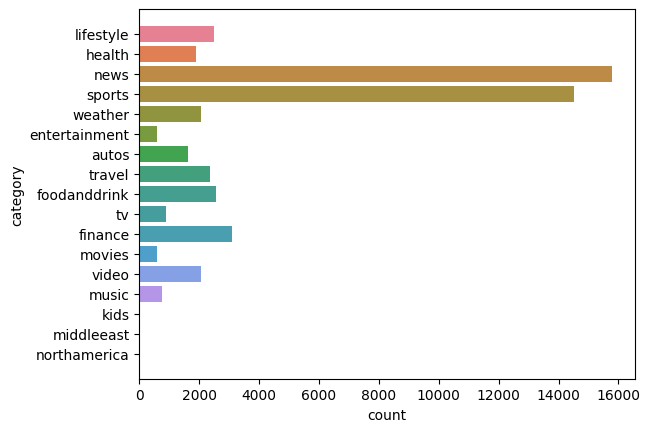

In [4]:
fig = eda_modules.plot_categories(news)
fig.plot()

### Missing Values in News
Examining the news dataset provided information about the count of missing values, all of which lie within the abstract, title entities and the abstract entities. Currently the abstract will not be utilized for recommendations. However, there is potential to creating an abstract from the web-scraped information from the article. (depending on time we shall see how this goes.)

In [5]:
copynews = news.set_index('news_id')
copynews.loc['N20121']


Unnamed: 0                                                       20003
category                                                         music
sub_category                                                 musicnews
title                   Bob Kingsley, Country Radio Legend, Dead at 80
abstract             Country radio legend Bob Kingley, the longtime...
url                      https://assets.msn.com/labs/mind/AAIW26m.html
title_entities       [{"Label": "Bob Kingsley", "Type": "P", "Wikid...
abstract_entities    [{"Label": "Bob Kingsley", "Type": "P", "Wikid...
Name: N20121, dtype: object

In [6]:
missing_vals = news.isna().sum()
# print(missing_vals.sum())
# news[missing_vals['abstract']] # can utilize this as a mask to get values where missing abstract is true in the main, to see if theres a
# majority of missing abstracts for a specific category
missing_vals
# sns.countplot(news,y='category',hue='category')
# sns.countplot(news[missing_vals['abstract']], color='red',y='category')

Unnamed: 0              0
news_id                 0
category                0
sub_category            0
title                   0
abstract             2666
url                     0
title_entities          3
abstract_entities       4
dtype: int64

### Moving on to Behaviors
The second large chunk of the microsoft news dataset is the behaviors file. Detailing user interactions, history, and times, the behaviors file provides our recommenders information it needs to train and determine what users might like. Additionally since there is an interaction time column, we can utilize temporal data and understand the affect it may have on our results. Starting off our exploration will be an examination into the potential missing values of the behaviors file

In [7]:
behaviors = pd.read_csv('../MIND_small/csv/behaviors.csv')

#### Missing values in behaviors
Within the behaviors file, there are certain users that do not have any history which can be a problem if these users have no history on their most recent interaction. If a user has no history whatsoever before the training cutoff point for time, then they must be removed as the recommender system will not generate anything for them that is personalized unless it is taking article popularity into account (hhmmmmm that might actually be a good idea is to take article popularity into account)

In [8]:
# print(len(pd.unique(behaviors['user_id'])))
# print(len(behaviors['user_id']))
# print(behaviors.columns)
# print(pd.unique(copynews['sub_category']))

# do missing value analysis on the behaviors csv
missing_behaviors = behaviors.isna().sum()
missing_behaviors

Unnamed: 0          0
impression_id       0
user_id             0
time                0
history          3238
impressions         0
dtype: int64

In [9]:
behaviors['time'] = pd.to_datetime(behaviors['time'])

## Gets the most recent time for interactions 
max_idcs = behaviors.groupby('user_id')['time'].idxmax()
max_behaviors = behaviors.loc[max_idcs]

# def swap_to_genres(history):
#     """ 
#     Swaps the articles in a users history to the corresponding genre
#     # """
#     # for interaction in history:
#     # copynews.loc['N55528']['category']

# ## could define a separate function that just creates a new dataframe, updating the column for each genre by 1 for every time an article appears in the maximum history of a user
    
def create_popularity_df():
    """ 
    Creates a dataframe with the popularity of every sub-category and category. The category popularity gets calculated as a biproduct of the sub-category popularity.
    """
    popoularity_dict = {category: 0 for category in pd.unique(copynews['category'])}
    for history in max_behaviors['history']:
        if type(history) != float:
            for news_id in history.split():
                sub_category = copynews.loc[news_id]['category']
                popoularity_dict[sub_category] += 1

    return pd.DataFrame(data=popoularity_dict, index=[1])

category_popularity = create_popularity_df()
category_popularity.head()

,lifestyle,health,news,sports,weather,entertainment,autos,travel,foodanddrink,tv,finance,movies,video,music,kids,middleeast,northamerica
1,98916,45253,278614,129298,10895,32444,33465,29762,49021,71786,68694,34881,18441,24560,10,18,0


<Axes: xlabel='value', ylabel='index'>

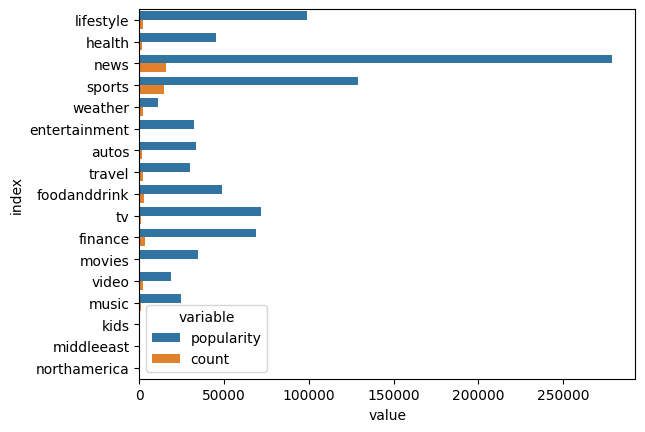

In [10]:
pop_long = category_popularity.melt(value_vars=category_popularity.columns, value_name='popularity')
news_cat = news['category'].value_counts().to_frame()
pop_long.set_index('variable', inplace=True)
concatenated = pd.concat([pop_long, news_cat], axis=1)
concatenated.reset_index(inplace=True)
# concatenated
sns.barplot(data=concatenated.melt(id_vars='index', value_vars=['popularity', 'count']),
            y='index',
            x='value',
            hue='variable')



### Interpreting the popularity
By analying the final tracked interactions of all users and checking their history, we can see that certain categories outweigh others in terms of rankings. Therefore we may consider creating weights for an inverse category frequency to ensure recommendations from the entire catalog. 

How do we then gauge the most popular genres, or times? 

### Accessing temporal aspects of our data
Within our data we have a time column, meaning that we can not only test and train with time in mind, but we can utilize this temporal aspect in our recommendations. As a result of this potential we have access to creating feature interactions based off of an interaction time. 

In [11]:
## Accessing temporal data ##
# how do we go about this? we can bin times into hours by finding the min and max time in the array
# then with our bins we can bin into hours, determining the categories by hours 

# first finding our min and max times

times = [behaviors['time'].max(), behaviors['time'].min()]
# max and then min
# print(times)
# interactions range from the 9th to the 14th, a span of 5 days, want to create bins of 1 hour
# 24 * 5 is 120 hours in total
cut_points = pd.date_range(start='2019-11-09 00:00:00', end='2019-11-15 00:00:00', freq='h') # hourly ranges for the time of the behaviors dataset
# cut_points = np.linspace(start=dataframe[col].min(), stop=dataframe[col].max(), num=5 + 1)
# print(type(cut_points))
behaviors_new = behaviors.copy()
bins_str = cut_points.astype(str).values

labels = ['({}, {}]'.format(bins_str[i-1], bins_str[i]) for i in range(1, len(bins_str))]
print(labels)
behaviors_new['time'] = pd.cut(behaviors['time'], cut_points, labels=labels, include_lowest=True)
# behaviors_new.head()
# might want to use df['toronto_time'] = pd.to_datetime(df['toronto_time']).dt.strftime('%H:%M:%S')
# def get_item_popularity()
# can change the create popularity df function to be applied on every group of time, or a bigger function that takes in a row
# popularity_by_time = behaviors_new.groupby('time').agg()
# df[["col1", "col2", ...]] = df.apply(lambda row: fn(row.text), axis='columns', result_type='expand')
behaviors_new['time'] = behaviors_new['time'].apply(lambda time_string : time_string.split(" ")[-1][:-1])
def clean_impression(impression : str = 'N55689-1') -> dict:
    """ 
    Cleans up a user impression for its characteristics.

    Args:
        impression (str) : A users impression on a recommended article.
    
    Returns:
        impression_info (dict) : A dictionary containing keys for the rating and article in the impression.
    """
    impression_info = impression.split('-')
    return {'score':impression_info[1], 'article_ID':impression_info[0]}    

# func should return a dictionary with column names as keys, we then can group by time, and then sum for each category
# then we can plot with strftime
STANDARD_DICT = {category: 0 for category in pd.unique(copynews['category'])}

def func(row):
    """ 
    Might want to change name from impression to interaction
    """
    user_interactions = row['impressions']
    cols_to_add = STANDARD_DICT.copy()
    if type(user_interactions) != float:
        for impression in user_interactions.split():
            impression_info = clean_impression(impression)
            if impression_info['score'] == '1':
                cols_to_add[copynews.loc[impression_info['article_ID']]['category']] += 1
    return cols_to_add

# print([category_popularity.columns.to_list()])
behaviors_new[category_popularity.columns.to_list()] = behaviors_new.apply(lambda row : func(row), axis='columns', result_type='expand')



# popularity_by_time[[category_popularity.columns]] = popularity_by_time.apply(lambda row : func(row))
# might just want to create a new dataframe with history and time 

['(2019-11-09 00:00:00, 2019-11-09 01:00:00]', '(2019-11-09 01:00:00, 2019-11-09 02:00:00]', '(2019-11-09 02:00:00, 2019-11-09 03:00:00]', '(2019-11-09 03:00:00, 2019-11-09 04:00:00]', '(2019-11-09 04:00:00, 2019-11-09 05:00:00]', '(2019-11-09 05:00:00, 2019-11-09 06:00:00]', '(2019-11-09 06:00:00, 2019-11-09 07:00:00]', '(2019-11-09 07:00:00, 2019-11-09 08:00:00]', '(2019-11-09 08:00:00, 2019-11-09 09:00:00]', '(2019-11-09 09:00:00, 2019-11-09 10:00:00]', '(2019-11-09 10:00:00, 2019-11-09 11:00:00]', '(2019-11-09 11:00:00, 2019-11-09 12:00:00]', '(2019-11-09 12:00:00, 2019-11-09 13:00:00]', '(2019-11-09 13:00:00, 2019-11-09 14:00:00]', '(2019-11-09 14:00:00, 2019-11-09 15:00:00]', '(2019-11-09 15:00:00, 2019-11-09 16:00:00]', '(2019-11-09 16:00:00, 2019-11-09 17:00:00]', '(2019-11-09 17:00:00, 2019-11-09 18:00:00]', '(2019-11-09 18:00:00, 2019-11-09 19:00:00]', '(2019-11-09 19:00:00, 2019-11-09 20:00:00]', '(2019-11-09 20:00:00, 2019-11-09 21:00:00]', '(2019-11-09 21:00:00, 2019-11-09

In [25]:

behaviors_final = behaviors_new.drop(columns=['Unnamed: 0', 'impression_id', 'user_id', 'history', 'impressions'])
                

behaviors_final = behaviors_final.groupby('time').agg('sum')
behaviors_final.reset_index(inplace=True)

/var/folders/83/h9nx83394pb5k_0h4zbb4lw00000gn/T/ipykernel_10514/1544821908.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,time,variable,value
0,0,lifestyle,185
1,1,lifestyle,146
2,2,lifestyle,169
3,3,lifestyle,251
4,4,lifestyle,446
...,...,...,...
403,19,northamerica,1
404,20,northamerica,0
405,21,northamerica,0
406,22,northamerica,0


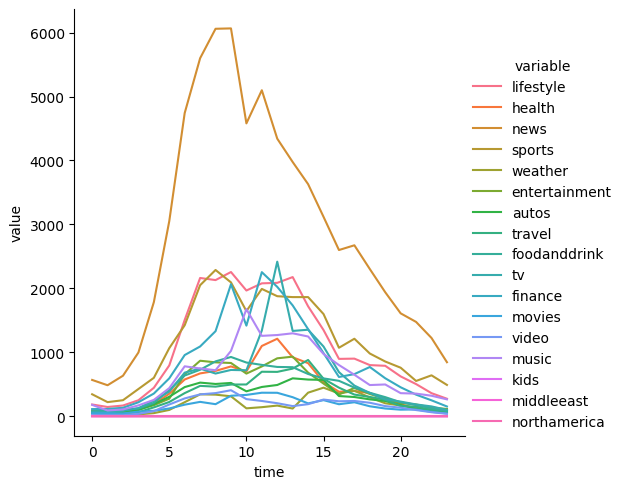

In [52]:


cols = ['lifestyle', 'health', 'news', 'sports', 'weather', 'entertainment', 'autos', 'travel', 'foodanddrink', 'tv', 'finance', 'movies', 'video', 'music', 'kids', 'middleeast', 'northamerica']
behaviors_long = behaviors_final.melt(id_vars='time', value_vars=cols)
behaviors_long['time'] = pd.to_datetime(behaviors_long['time'])
behaviors_long['time'] = behaviors_long['time'].dt.hour

sns.relplot(behaviors_long, x='time', y='value', hue='variable', kind='line')
behaviors_long

###  meep
Within the context of a recommender we do not care about the date exactly but more so the hour or time of day, hence we will change the bins accordingly 